# Notebook 2 — Correlations + OLS (HAC/Newey–West) + lag effects + saved tables/plots

Этот ноутбук предполагает, что Notebook 1 уже создал файлы в папке `data/`:
- `final_features_all.parquet` (минимум: `date, ticker, returns, RSI, MACD, I_t`)
- опционально: `news_scored_all.parquet` (для расширенных индексов новостного фона)

**Что делает ноутбук:**
1) строит расширенные дневные индексы новостей: `I_t`, `I_t_max`, `N_t_strong`, `n_news` (если есть scored news);
2) считает корреляции (в т.ч. по лагам);
3) оценивает 2–3 OLS-модели с HAC(Newey–West) ошибками;
4) оценивает distributed-lag модель и сохраняет график β_k по лагам;
5) сохраняет 2–3 таблицы и 2–3 графика в `outputs/`.


In [1]:
# (Опционально) зависимости. Можно закомментировать, если всё уже установлено.
import importlib, sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Базовые пакеты
for pkg in ["matplotlib", "statsmodels"]:
    try:
        importlib.import_module(pkg)
    except Exception:
        pip_install([pkg])

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

DATA_DIR = Path("data")


In [2]:
# --- Parquet read helper (устойчиво к pyarrow/pandas extension type ошибкам) ---
_PARQUET_ENGINE = None
try:
    import fastparquet  # noqa: F401
    _PARQUET_ENGINE = "fastparquet"
except Exception:
    _PARQUET_ENGINE = "pyarrow"

def _reset_pyarrow_pandas_ext_types():
    try:
        import pyarrow as pa
    except Exception:
        return
    for name in ("pandas.period", "pandas.interval"):
        try:
            pa.unregister_extension_type(name)
        except Exception:
            pass

def safe_read_parquet(path: Path) -> pd.DataFrame:
    try:
        return pd.read_parquet(path, engine=_PARQUET_ENGINE)
    except Exception as e:
        msg = str(e)
        if ("type extension with name pandas." in msg and "already defined" in msg) or "ArrowKeyError" in msg:
            _reset_pyarrow_pandas_ext_types()
            return pd.read_parquet(path, engine=_PARQUET_ENGINE)
        raise

print("Parquet engine:", _PARQUET_ENGINE)


Parquet engine: pyarrow


In [3]:
# --- Load main merged dataset from Notebook 1 ---
df = safe_read_parquet(DATA_DIR / "final_features_all.parquet").copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker","date"]).reset_index(drop=True)

# Нормализуем имена колонок на всякий случай
df.columns = [str(c).strip() for c in df.columns]

df.head()


,ticker,date,returns,RSI,MACD,I_t
0,AAPL,2020-12-29,NaN,NaN,0.000000,-0.527073
1,AAPL,2020-12-30,-0.008527,0.000000,-0.089302,-0.122154
2,AAPL,2020-12-31,-0.007703,0.000000,-0.238232,NaN
3,AAPL,2021-01-04,-0.024719,0.000000,-0.606907,0.659435
4,AAPL,2021-01-05,0.012364,8.684289,-0.764590,-0.162034


In [4]:
# --- Optional: build extra daily news indices from scored news (если файл существует) ---
news_path = DATA_DIR / "news_scored_all.parquet"
if news_path.exists():
    news = safe_read_parquet(news_path).copy()
    # ожидаем: date, ticker, s_x
    if "date" in news.columns:
        news["date"] = pd.to_datetime(news["date"])
    else:
        raise RuntimeError("news_scored_all.parquet must contain 'date' column")

    if "ticker" not in news.columns:
        raise RuntimeError("news_scored_all.parquet must contain 'ticker' column")

    # s_x может называться иначе
    if "s_x" not in news.columns:
        # попытка найти близкую колонку
        cand = [c for c in news.columns if c.lower() in ("sx", "sentiment", "score")]
        if cand:
            news["s_x"] = pd.to_numeric(news[cand[0]], errors="coerce")
        else:
            raise RuntimeError("news_scored_all.parquet must contain 's_x' column (p_pos - p_neg)")

    news["s_x"] = pd.to_numeric(news["s_x"], errors="coerce")
    news = news.dropna(subset=["date","ticker","s_x"]).copy()

    # Порог "сильных" новостей (зафиксируйте и используйте в тексте)
    STRONG_THR = 0.5

    daily_news = (
        news.groupby(["ticker","date"])
        .agg(
            I_t=("s_x","mean"),
            I_t_max=("s_x", lambda x: float(np.nanmax(np.abs(x.values))) if len(x) else np.nan),
            N_t_strong=("s_x", lambda x: int(np.sum(np.abs(x.values) >= STRONG_THR))),
            n_news=("s_x","size"),
            I_t_pos=("s_x", lambda x: float(np.nanmean(x[x>0])) if np.any(x>0) else np.nan),
            I_t_neg=("s_x", lambda x: float(np.nanmean(x[x<0])) if np.any(x<0) else np.nan),
        )
        .reset_index()
    )

    # Мержим поверх df: если в df уже есть I_t, обновим только пропуски
    df = df.merge(daily_news, on=["ticker","date"], how="left", suffixes=("","_from_news"))
    # если в df не было I_t — теперь есть; если было — оставим существующее, но заполним NaN из news
    if "I_t_from_news" in df.columns:
        df["I_t"] = df["I_t"].where(df["I_t"].notna(), df["I_t_from_news"])
        df = df.drop(columns=["I_t_from_news"])
    print("Merged daily news indices from:", news_path)
else:
    STRONG_THR = 0.5
    # если нет файла — оставим как есть, но создадим пустые колонки, чтобы downstream код не падал
    for c in ["I_t_max","N_t_strong","n_news","I_t_pos","I_t_neg"]:
        if c not in df.columns:
            df[c] = np.nan
    print("No scored news file found. Using only I_t from final_features_all.parquet (if present).")

df.head()


Merged daily news indices from: data/news_scored_all.parquet


,ticker,date,returns,RSI,MACD,I_t,I_t_max,N_t_strong,n_news,I_t_pos,I_t_neg
0,AAPL,2020-12-29,NaN,NaN,0.000000,-0.527073,0.527073,1.0,1.0,NaN,-0.527073
1,AAPL,2020-12-30,-0.008527,0.000000,-0.089302,-0.122154,0.878942,2.0,2.0,0.634633,-0.878942
2,AAPL,2020-12-31,-0.007703,0.000000,-0.238232,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2021-01-04,-0.024719,0.000000,-0.606907,0.659435,0.892991,1.0,2.0,0.659435,NaN
4,AAPL,2021-01-05,0.012364,8.684289,-0.764590,-0.162034,0.510277,1.0,3.0,0.060650,-0.273376


In [5]:
# --- Build market targets/features: log-returns, next-day return, deltas, lags ---
df = df.sort_values(["ticker","date"]).copy()

# Лог-доходности: если есть adj_close/close — используем, иначе лог(1+returns)
if "adj_close" in df.columns:
    px = pd.to_numeric(df["adj_close"], errors="coerce")
    df["r_log"] = np.log(px).groupby(df["ticker"]).diff()
elif "close" in df.columns:
    px = pd.to_numeric(df["close"], errors="coerce")
    df["r_log"] = np.log(px).groupby(df["ticker"]).diff()
else:
    # fallback: returns уже есть (pct_change), переводим в log-return
    df["r_log"] = np.log1p(pd.to_numeric(df["returns"], errors="coerce"))

# next-day return (честнее для интерпретации "новости сегодня → рынок завтра")
df["r_log_fwd1"] = df.groupby("ticker")["r_log"].shift(-1)

# ΔRSI, ΔMACD
df["dRSI"] = df.groupby("ticker")["RSI"].diff()
df["dMACD"] = df.groupby("ticker")["MACD"].diff()

# Лаги
for k in [1,2]:
    df[f"r_log_lag{k}"] = df.groupby("ticker")["r_log"].shift(k)
    df[f"I_t_lag{k}"] = df.groupby("ticker")["I_t"].shift(k)

# Заполним n_news если нет
if "n_news" not in df.columns:
    df["n_news"] = np.nan

df[["date","ticker","r_log","r_log_fwd1","I_t","I_t_max","N_t_strong","n_news","RSI","MACD"]].head(10)


,date,ticker,r_log,r_log_fwd1,I_t,I_t_max,N_t_strong,n_news,RSI,MACD
0,2020-12-29,AAPL,NaN,-0.008563,-0.527073,0.527073,1.0,1.0,NaN,0.000000
1,2020-12-30,AAPL,-0.008563,-0.007732,-0.122154,0.878942,2.0,2.0,0.000000,-0.089302
2,2020-12-31,AAPL,-0.007732,-0.025030,NaN,NaN,NaN,NaN,0.000000,-0.238232
3,2021-01-04,AAPL,-0.025030,0.012288,0.659435,0.892991,1.0,2.0,0.000000,-0.606907
4,2021-01-05,AAPL,0.012288,-0.034241,-0.162034,0.510277,1.0,3.0,8.684289,-0.764590
5,2021-01-06,AAPL,-0.034241,0.033554,-0.073685,0.262288,0.0,3.0,6.904499,-1.221875
6,2021-01-07,AAPL,0.033554,0.008594,NaN,NaN,NaN,NaN,23.453919,-1.230757
7,2021-01-08,AAPL,0.008594,-0.023523,-0.006052,0.006052,0.0,1.0,27.104323,-1.135940
8,2021-01-11,AAPL,-0.023523,-0.001397,NaN,NaN,NaN,NaN,23.785614,-1.287105
9,2021-01-12,AAPL,-0.001397,0.016097,NaN,NaN,NaN,NaN,23.603112,-1.404850


## 1) Корреляционный анализ (в т.ч. лаги)

Сохраняем:
- `outputs/corr_keypairs.csv` — ключевые корреляции по тикерам
- `outputs/corr_lags_<TICKER>.csv` — корреляции по лагам `corr(I_{t-k}, r_{t+1})`, k=0..K


In [6]:
# --- Key pair correlations + lag correlations ---
K = 5  # число лагов для анализа
rows = []

for t, g in df.groupby("ticker"):
    g = g.sort_values("date").copy()

    # ключевые пары
    pairs = {
        "corr(I_t, r_log)": (g["I_t"], g["r_log"]),
        "corr(I_t, r_log_fwd1)": (g["I_t"], g["r_log_fwd1"]),
        "corr(I_t, dRSI)": (g["I_t"], g["dRSI"]),
        "corr(I_t, dMACD)": (g["I_t"], g["dMACD"]),
    }
    for name,(a,b) in pairs.items():
        val = pd.concat([a,b], axis=1).dropna().corr().iloc[0,1]
        rows.append({"ticker": t, "metric": name, "value": float(val)})

    # лаги: corr(I_{t-k}, r_{t+1})
    lag_rows = []
    for k in range(0, K+1):
        Ik = g["I_t"].shift(k)
        rr = g["r_log_fwd1"]
        val = pd.concat([Ik, rr], axis=1).dropna().corr().iloc[0,1]
        lag_rows.append({"ticker": t, "lag": k, "corr_I_lagk_vs_r_fwd1": float(val)})
    lag_df = pd.DataFrame(lag_rows)
    lag_df.to_csv(OUT_DIR / f"corr_lags_{t}.csv", index=False)

corr_keypairs = pd.DataFrame(rows)
corr_keypairs.to_csv(OUT_DIR / "corr_keypairs.csv", index=False)

corr_keypairs.pivot(index="metric", columns="ticker", values="value")


ticker,AAPL,XOM
metric,,
"corr(I_t, dMACD)",0.079764,-0.025311
"corr(I_t, dRSI)",0.072821,-0.016777
"corr(I_t, r_log)",0.086924,-0.027614
"corr(I_t, r_log_fwd1)",0.005273,0.039453


## 2) OLS-регрессии с HAC(Newey–West) SE

Модели (по каждому тикеру отдельно):
- **M1:** `r_{t+1} ~ I_t`
- **M2:** `r_{t+1} ~ I_t + r_t + r_{t-1} + RSI_t + MACD_t`
- **M3 (опц.):** `dRSI_t ~ I_t` (пример влияния на тех-индикатор)

Сохраняем:
- `outputs/ols_coeffs.csv`
- `outputs/ols_summary_by_ticker.csv` (агрегированно: nobs, R2 и т.д.)


In [7]:
def fit_ols_hac(g: pd.DataFrame, y: str, x: list[str], maxlags: int = 5):
    d = g[["date","ticker", y] + x].dropna().copy()
    Y = d[y].astype(float)
    X = sm.add_constant(d[x].astype(float))
    m = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
    return d, m

maxlags = 5

coef_rows = []
sum_rows = []

for t, g in df.groupby("ticker"):
    g = g.sort_values("date").copy()

    # M1
    d1, m1 = fit_ols_hac(g, "r_log_fwd1", ["I_t"], maxlags=maxlags)

    # M2
    d2, m2 = fit_ols_hac(g, "r_log_fwd1", ["I_t","r_log","r_log_lag1","RSI","MACD"], maxlags=maxlags)

    # M3 (опционально)
    d3, m3 = fit_ols_hac(g, "dRSI", ["I_t"], maxlags=maxlags)

    models = [("M1_r_fwd1", m1), ("M2_r_fwd1_controls", m2), ("M3_dRSI", m3)]

    for name, m in models:
        for term in m.params.index:
            coef_rows.append({
                "ticker": t,
                "model": name,
                "term": term,
                "coef": float(m.params[term]),
                "std_err": float(m.bse[term]),
                "p_value": float(m.pvalues[term]),
            })
        sum_rows.append({
            "ticker": t, "model": name, "nobs": int(m.nobs), "r2": float(m.rsquared)
        })

    print(f"{t}: M1 R2={m1.rsquared:.4f} | M2 R2={m2.rsquared:.4f} | M3 R2={m3.rsquared:.4f}")
    display(m2.summary().tables[1])

ols_coeffs = pd.DataFrame(coef_rows)
ols_summary = pd.DataFrame(sum_rows)

ols_coeffs.to_csv(OUT_DIR / "ols_coeffs.csv", index=False)
ols_summary.to_csv(OUT_DIR / "ols_summary_by_ticker.csv", index=False)

ols_coeffs.head()


AAPL: M1 R2=0.0000 | M2 R2=0.0019 | M3 R2=0.0053


,coef,std err,z,P>|z|,[0.025,0.975]
const,3.529e-05,0.006,0.006,0.995,-0.012,0.012
I_t,7.328e-05,0.001,0.050,0.960,-0.003,0.003
r_log,0.0253,0.071,0.359,0.720,-0.113,0.164
r_log_lag1,0.0298,0.061,0.484,0.628,-0.091,0.150
RSI,-5.394e-06,0.000,-0.042,0.966,-0.000,0.000
MACD,9.344e-05,0.001,0.173,0.863,-0.001,0.001


XOM: M1 R2=0.0016 | M2 R2=0.0106 | M3 R2=0.0003


,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0062,0.007,-0.897,0.369,-0.020,0.007
I_t,0.0014,0.001,1.055,0.292,-0.001,0.004
r_log,0.0338,0.057,0.588,0.556,-0.079,0.147
r_log_lag1,-0.0236,0.048,-0.492,0.623,-0.118,0.071
RSI,0.0001,0.000,1.121,0.262,-0.000,0.000
MACD,-0.0015,0.001,-1.348,0.178,-0.004,0.001


,ticker,model,term,coef,std_err,p_value
0,AAPL,M1_r_fwd1,const,-0.000142,0.000635,0.822317
1,AAPL,M1_r_fwd1,I_t,0.000205,0.001453,0.887682
2,AAPL,M2_r_fwd1_controls,const,0.000035,0.006215,0.995470
3,AAPL,M2_r_fwd1_controls,I_t,0.000073,0.001460,0.959982
4,AAPL,M2_r_fwd1_controls,r_log,0.025350,0.070604,0.719563


## 3) Анализ лаговых эффектов (distributed lag)

Оцениваем (по тикеру):
`r_{t+1} ~ I_t + I_{t-1} + ... + I_{t-K} + controls`

Сохраняем:
- `outputs/ols_lag_coeffs.csv`
- `outputs/lag_betas_<TICKER>.png` — график β_k по лагам


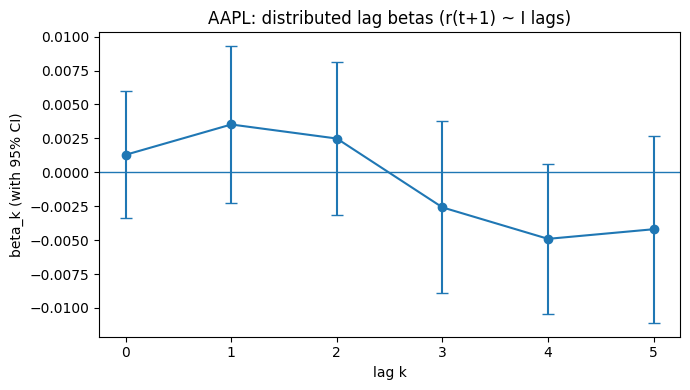

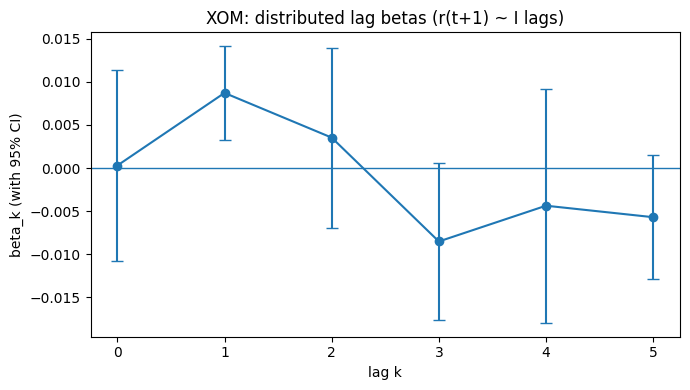

,ticker,lag,term,coef,std_err,p_value,nobs,r2
0,AAPL,0,I_lag0,0.001292,0.002397,0.589777,127,0.072469
1,AAPL,1,I_lag1,0.003526,0.002946,0.231414,127,0.072469
2,AAPL,2,I_lag2,0.002489,0.002894,0.389629,127,0.072469
3,AAPL,3,I_lag3,-0.002587,0.003238,0.424350,127,0.072469
4,AAPL,4,I_lag4,-0.004907,0.002827,0.082621,127,0.072469


In [8]:
K = 5
maxlags = 5

lag_coef_rows = []

for t, g in df.groupby("ticker"):
    g = g.sort_values("date").copy()

    # создаём лаги I_t
    for k in range(0, K+1):
        g[f"I_lag{k}"] = g["I_t"].shift(k)

    x_cols = [f"I_lag{k}" for k in range(0, K+1)] + ["r_log","r_log_lag1","RSI","MACD"]
    d, m = fit_ols_hac(g, "r_log_fwd1", x_cols, maxlags=maxlags)

    # вытаскиваем β_k
    betas = []
    ses = []
    for k in range(0, K+1):
        term = f"I_lag{k}"
        betas.append(float(m.params.get(term, np.nan)))
        ses.append(float(m.bse.get(term, np.nan)))
        lag_coef_rows.append({
            "ticker": t,
            "lag": k,
            "term": term,
            "coef": float(m.params.get(term, np.nan)),
            "std_err": float(m.bse.get(term, np.nan)),
            "p_value": float(m.pvalues.get(term, np.nan)),
            "nobs": int(m.nobs),
            "r2": float(m.rsquared),
        })

    # график β_k ± 1.96*SE
    ks = np.arange(0, K+1)
    betas = np.array(betas)
    ses = np.array(ses)
    ci = 1.96 * ses

    fig, ax = plt.subplots(figsize=(7,4))
    ax.axhline(0, linewidth=1)
    ax.errorbar(ks, betas, yerr=ci, fmt="o-", capsize=4)
    ax.set_title(f"{t}: distributed lag betas (r(t+1) ~ I lags)")
    ax.set_xlabel("lag k")
    ax.set_ylabel("beta_k (with 95% CI)")
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"lag_betas_{t}.png", dpi=150)
    plt.show()

lag_coeffs = pd.DataFrame(lag_coef_rows)
lag_coeffs.to_csv(OUT_DIR / "ols_lag_coeffs.csv", index=False)
lag_coeffs.head()


## 4) 2–3 графика + (лёгкая) out-of-sample проверка

Сохраняем:
- `outputs/timeseries_<TICKER>.png` — I_t и r_{t+1}
- `outputs/scatter_<TICKER>.png` — scatter r_{t+1} vs I_t + line
- `outputs/oos_metrics.csv` — MSE на test (M1 vs baseline)


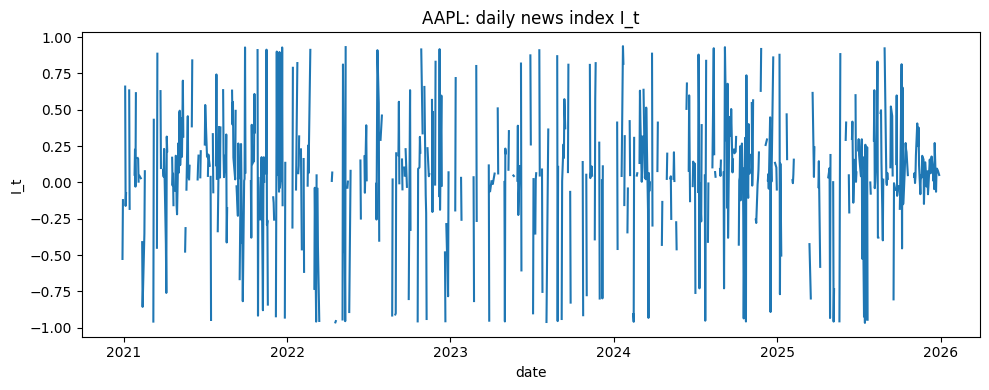

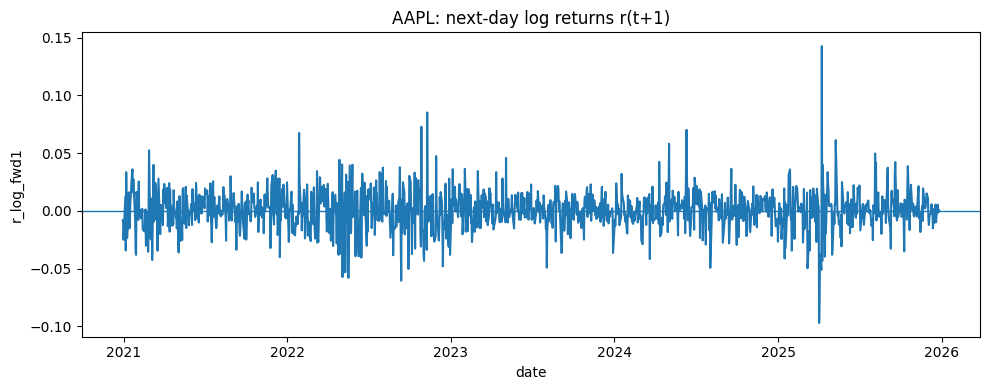

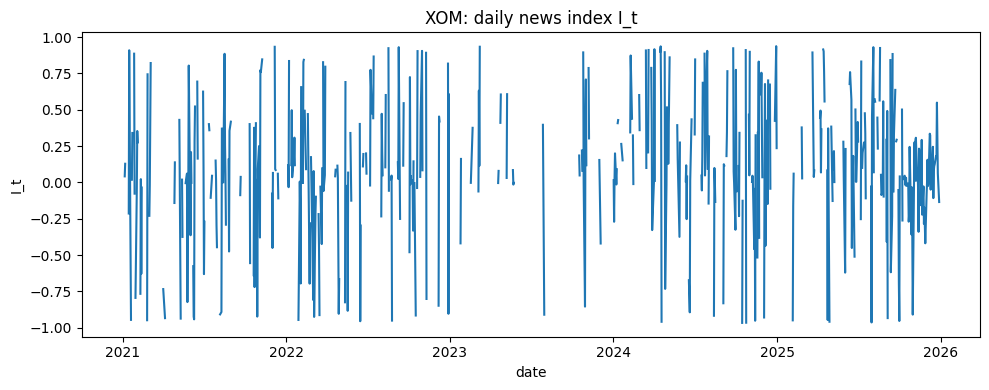

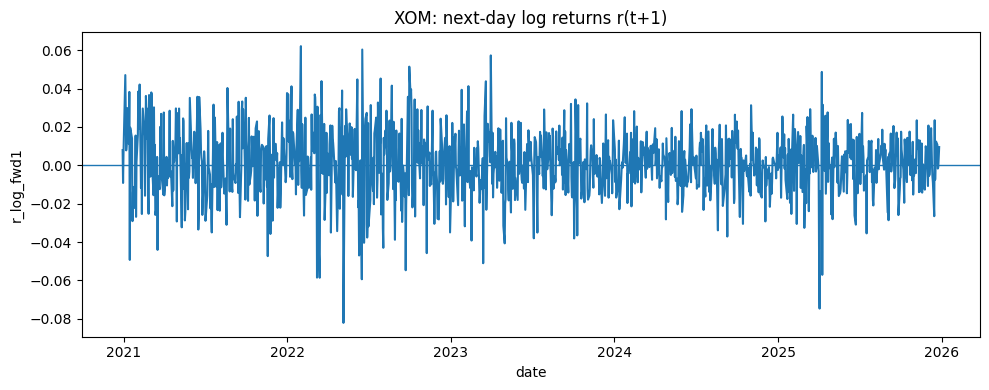

In [9]:
# --- Plot 1: time series I_t and next-day log-return ---
for t, g in df.groupby("ticker"):
    g = g.sort_values("date").copy()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(g["date"], g["I_t"], label="I_t")
    ax.set_title(f"{t}: daily news index I_t")
    ax.set_xlabel("date")
    ax.set_ylabel("I_t")
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"timeseries_I_t_{t}.png", dpi=150)
    plt.show()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(g["date"], g["r_log_fwd1"], label="r_{t+1}")
    ax.axhline(0, linewidth=1)
    ax.set_title(f"{t}: next-day log returns r(t+1)")
    ax.set_xlabel("date")
    ax.set_ylabel("r_log_fwd1")
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"timeseries_r_fwd1_{t}.png", dpi=150)
    plt.show()


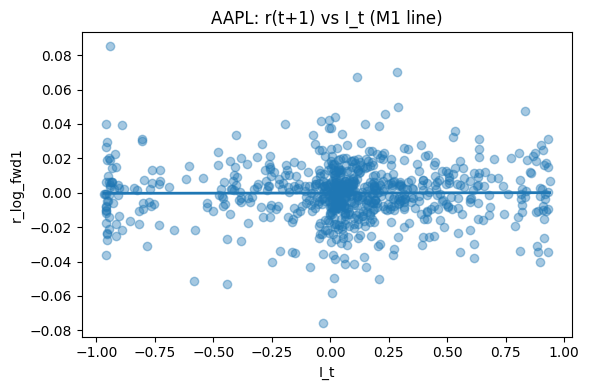

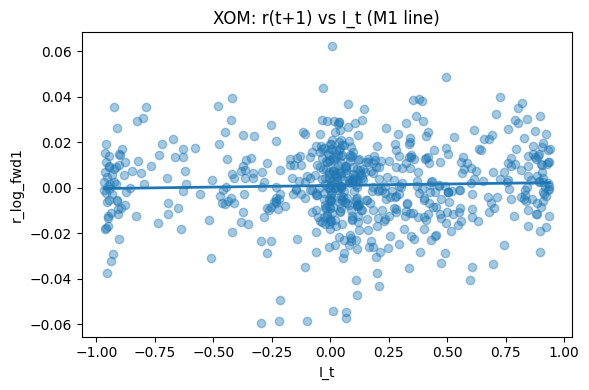

In [10]:
# --- Plot 2: scatter r_{t+1} vs I_t + OLS line (M1) ---
for t, g in df.groupby("ticker"):
    d = g[["I_t","r_log_fwd1"]].dropna().copy()
    if len(d) < 20:
        continue

    X = sm.add_constant(d["I_t"].astype(float))
    y = d["r_log_fwd1"].astype(float)
    m = sm.OLS(y, X).fit()

    xs = np.linspace(d["I_t"].min(), d["I_t"].max(), 100)
    ys = m.params["const"] + m.params["I_t"] * xs

    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(d["I_t"], d["r_log_fwd1"], alpha=0.4)
    ax.plot(xs, ys, linewidth=2)
    ax.set_title(f"{t}: r(t+1) vs I_t (M1 line)")
    ax.set_xlabel("I_t")
    ax.set_ylabel("r_log_fwd1")
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"scatter_r_fwd1_vs_I_t_{t}.png", dpi=150)
    plt.show()


In [11]:
# --- Out-of-sample (time split) quick check: baseline vs M1 ---
oos_rows = []

for t, g in df.groupby("ticker"):
    g = g.sort_values("date").copy()
    d = g[["date","I_t","r_log_fwd1"]].dropna().copy()
    if len(d) < 100:
        continue

    split_idx = int(len(d) * 0.8)
    train = d.iloc[:split_idx].copy()
    test  = d.iloc[split_idx:].copy()

    # baseline: predict mean(train)
    y_mean = train["r_log_fwd1"].mean()
    pred_base = np.full(len(test), y_mean)

    # M1: r_fwd1 ~ I_t
    Xtr = sm.add_constant(train["I_t"].astype(float))
    ytr = train["r_log_fwd1"].astype(float)
    m1 = sm.OLS(ytr, Xtr).fit()

    Xte = sm.add_constant(test["I_t"].astype(float))
    pred_m1 = m1.predict(Xte)

    mse_base = float(np.mean((test["r_log_fwd1"].values - pred_base)**2))
    mse_m1 = float(np.mean((test["r_log_fwd1"].values - pred_m1.values)**2))

    oos_rows.append({"ticker": t, "n_train": len(train), "n_test": len(test), "mse_baseline": mse_base, "mse_M1": mse_m1})

oos = pd.DataFrame(oos_rows)
oos.to_csv(OUT_DIR / "oos_metrics.csv", index=False)
oos


,ticker,n_train,n_test,mse_baseline,mse_M1
0,AAPL,581,146,0.000273,0.000273
1,XOM,497,125,0.000165,0.000165


## 5) Intraday (1h) анализ + простейший event study (если есть файл из Notebook 1)

Если существует `data/final_features_intraday_1h.parquet`, то:
- считаем корреляции `corr(I_h, r_fwd1h)` и лаги;
- оцениваем 1–2 OLS (HAC) на часовой частоте;
- делаем простой event-study по новостям (CAR на горизонтах 1h и 3h).

In [12]:

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm

intr_path = DATA_DIR / "final_features_intraday_1h.parquet"
news_scored_path = DATA_DIR / "news_scored_all.parquet"

if not intr_path.exists():
    print("No intraday file:", intr_path, "→ пропускаем intraday блок.")
else:
    intr = safe_read_parquet(intr_path).dropna(subset=["datetime","ticker"]).copy()
    intr["datetime"] = pd.to_datetime(intr["datetime"])
    intr = intr.sort_values(["ticker","datetime"])

    # --- 5.1 Correlations (key pairs) ---
    rows = []
    for t, g in intr.groupby("ticker"):
        g = g.dropna(subset=["I_h","r_fwd1h"])
        if len(g) >= 30:
            rows.append({"ticker": t, "pair": "corr(I_h, r_fwd1h)", "corr": g["I_h"].corr(g["r_fwd1h"])})
        g2 = intr[intr["ticker"] == t].dropna(subset=["I_h","r_fwd3h"])
        if len(g2) >= 30:
            rows.append({"ticker": t, "pair": "corr(I_h, r_fwd3h)", "corr": g2["I_h"].corr(g2["r_fwd3h"])})
    corr_intr = pd.DataFrame(rows)
    corr_intr.to_csv(OUT_DIR / "corr_intraday_keypairs.csv", index=False)
    display(corr_intr)

    # --- 5.2 Lag correlations: corr(I_{h-k}, r_{h->h+1}) ---
    K = 12  # 12 часов лагов
    for t, g in intr.groupby("ticker"):
        g = g.sort_values("datetime").copy()
        out = []
        for k in range(0, K+1):
            x = g["I_h"].shift(k)
            y = g["r_fwd1h"]
            m = pd.concat([x, y], axis=1).dropna()
            out.append({"ticker": t, "lag_hours": k, "corr": m.iloc[:,0].corr(m.iloc[:,1]) if len(m) >= 30 else np.nan, "n": len(m)})
        out = pd.DataFrame(out)
        out.to_csv(OUT_DIR / f"corr_intraday_lags_{t}.csv", index=False)

    # --- 5.3 OLS (HAC): r_{h+1} ~ I_h (+ control r_h) ---
    ols_rows = []
    for t, g in intr.groupby("ticker"):
        g = g.sort_values("datetime").copy()
        # hour return as control
        g["r_1h"] = g["adj_close"].pct_change()
        reg = g.dropna(subset=["r_fwd1h","I_h"]).copy()
        if len(reg) < 200:
            print(f"{t}: too few rows for intraday OLS:", len(reg))
            continue

        # M1: r_fwd1h ~ I_h
        X1 = sm.add_constant(reg[["I_h"]])
        m1 = sm.OLS(reg["r_fwd1h"], X1).fit(cov_type="HAC", cov_kwds={"maxlags": 12})

        # M2: r_fwd1h ~ I_h + r_1h (lag return)
        reg2 = reg.dropna(subset=["r_1h"]).copy()
        X2 = sm.add_constant(reg2[["I_h","r_1h"]])
        m2 = sm.OLS(reg2["r_fwd1h"], X2).fit(cov_type="HAC", cov_kwds={"maxlags": 12})

        for name, m in [("M1", m1), ("M2", m2)]:
            ols_rows.append({
                "ticker": t,
                "model": name,
                "coef_I": float(m.params.get("I_h", np.nan)),
                "t_I": float(m.tvalues.get("I_h", np.nan)),
                "p_I": float(m.pvalues.get("I_h", np.nan)),
                "n": int(m.nobs),
                "R2": float(m.rsquared),
            })

        # save text summaries
        with open(OUT_DIR / f"ols_intraday_{t}_M1.txt", "w") as f:
            f.write(m1.summary().as_text())
        with open(OUT_DIR / f"ols_intraday_{t}_M2.txt", "w") as f:
            f.write(m2.summary().as_text())

    ols_intr = pd.DataFrame(ols_rows)
    ols_intr.to_csv(OUT_DIR / "ols_intraday_coeffs.csv", index=False)
    display(ols_intr)

    # --- 5.4 Simple Event Study (CAR over 1h and 3h) ---
    if not news_scored_path.exists():
        print("No news scored file:", news_scored_path, "→ пропускаем event-study.")
    else:
        news = safe_read_parquet(news_scored_path).dropna(subset=["ticker","published_at","s_x"]).copy()
        news["published_at"] = pd.to_datetime(news["published_at"])

        TAU = 0.5
        def classify(s):
            if s >= TAU: return "pos_strong"
            if s <= -TAU: return "neg_strong"
            return "other"

        ev_rows = []
        for t, gnews in news.groupby("ticker"):
            gprice = intr[intr["ticker"] == t].sort_values("datetime").copy()
            times = gprice["datetime"].values
            # map each event to the next available bar time
            idxs = np.searchsorted(times, gnews["published_at"].values, side="left")
            for s_x, idx in zip(gnews["s_x"].values, idxs):
                if idx < 0 or idx >= len(gprice):
                    continue
                r1 = gprice.iloc[idx]["r_fwd1h"] if "r_fwd1h" in gprice.columns else np.nan
                r3 = gprice.iloc[idx]["r_fwd3h"] if "r_fwd3h" in gprice.columns else np.nan
                ev_rows.append({"ticker": t, "bucket": classify(s_x), "s_x": float(s_x), "CAR_1h": r1, "CAR_3h": r3})

        ev = pd.DataFrame(ev_rows).dropna(subset=["CAR_1h","bucket"])
        if ev.empty:
            print("Event-study: no aligned events (likely low overlap между intraday ценами и новостями).")
        else:
            summary = (
                ev.groupby(["ticker","bucket"], as_index=False)
                  .agg(n=("CAR_1h","size"),
                       mean_CAR_1h=("CAR_1h","mean"),
                       mean_CAR_3h=("CAR_3h","mean"))
            )
            summary.to_csv(OUT_DIR / "event_study_summary.csv", index=False)
            display(summary)

            # Plot: mean CAR by bucket (per ticker)
            for t in summary["ticker"].unique():
                s = summary[summary["ticker"] == t].copy()
                fig = plt.figure()
                plt.bar(s["bucket"], s["mean_CAR_1h"])
                plt.title(f"{t}: mean CAR 1h by sentiment bucket")
                plt.xticks(rotation=20)
                plt.tight_layout()
                fig.savefig(OUT_DIR / f"event_study_car1h_{t}.png", dpi=150)
                plt.close(fig)


,ticker,pair,corr
0,AAPL,"corr(I_h, r_fwd1h)",0.038157
1,AAPL,"corr(I_h, r_fwd3h)",0.008306
2,XOM,"corr(I_h, r_fwd1h)",0.072065
3,XOM,"corr(I_h, r_fwd3h)",0.122736


,ticker,model,coef_I,t_I,p_I,n,R2
0,AAPL,M1,0.000331,0.720969,0.470928,407,0.001456
1,AAPL,M2,0.000324,0.695655,0.486645,407,0.004305
2,XOM,M1,0.000539,1.648556,0.099239,354,0.005193
3,XOM,M2,0.000519,1.562097,0.118265,354,0.007514


,ticker,bucket,n,mean_CAR_1h,mean_CAR_3h
0,AAPL,neg_strong,499,0.000057,-0.001201
1,AAPL,other,2309,0.000012,-0.001109
2,AAPL,pos_strong,792,0.000151,-0.000509
3,XOM,neg_strong,837,0.001338,-0.006598
4,XOM,other,1368,0.001271,0.000147
5,XOM,pos_strong,547,0.001344,0.000156
